In [1]:
!pip install wfdb matplotlib numpy scipy

Libraries

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

Load ECG Data

Loaded record '100' with sampling rate 360 Hz


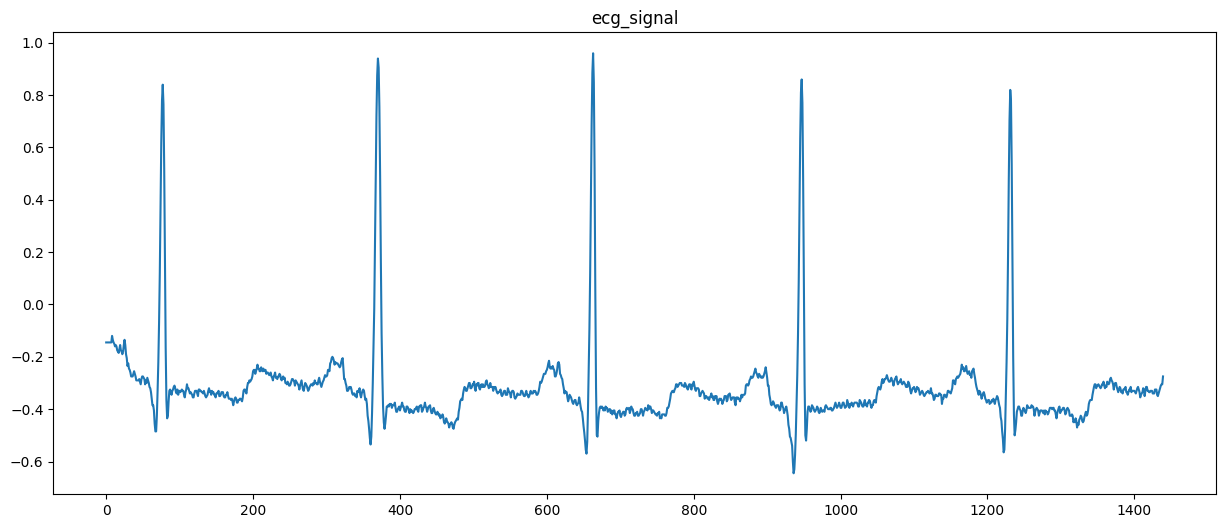

In [54]:
record_name = '100'  # Replace with your .dat file name (without extension)
   
    # Read the .dat file using wfdb
try:
    record = wfdb.rdrecord(record_name)
    ecg_signal = record.p_signal[:, 0]
    fs = record.fs  # Sampling frequency (Hz)
    
    samp_sec = 4  # Number of seconds to plot
    # num_samples = int(120 * fs)  # Number of samples in 120 seconds
    num_samples = int(samp_sec * fs)
    ecg_signal = ecg_signal[:num_samples]
    print(f"Loaded record '{record_name}' with sampling rate {fs} Hz")
except FileNotFoundError:
    print(f"Error: Record '{record_name}' not found. Check PhysioNet access.")

plt.figure(figsize=(15, 6))    
plt.plot(ecg_signal)
plt.title("ecg_signal")
plt.show()
    

Amplitude Normalization

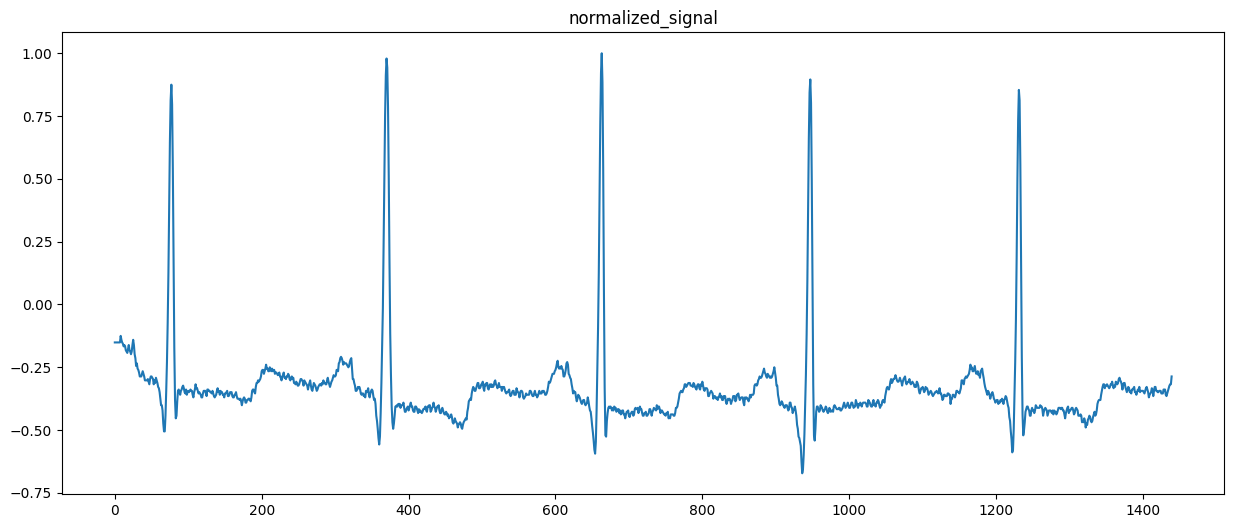

In [55]:
def amplitude_normalization(signal):
    return signal / np.max(np.abs(signal))

normalized_signal = amplitude_normalization(ecg_signal)
plt.figure(figsize=(15, 6))
plt.plot(normalized_signal)
plt.title("normalized_signal")
plt.show()

Bandpass Filtering (0.5–40 Hz)

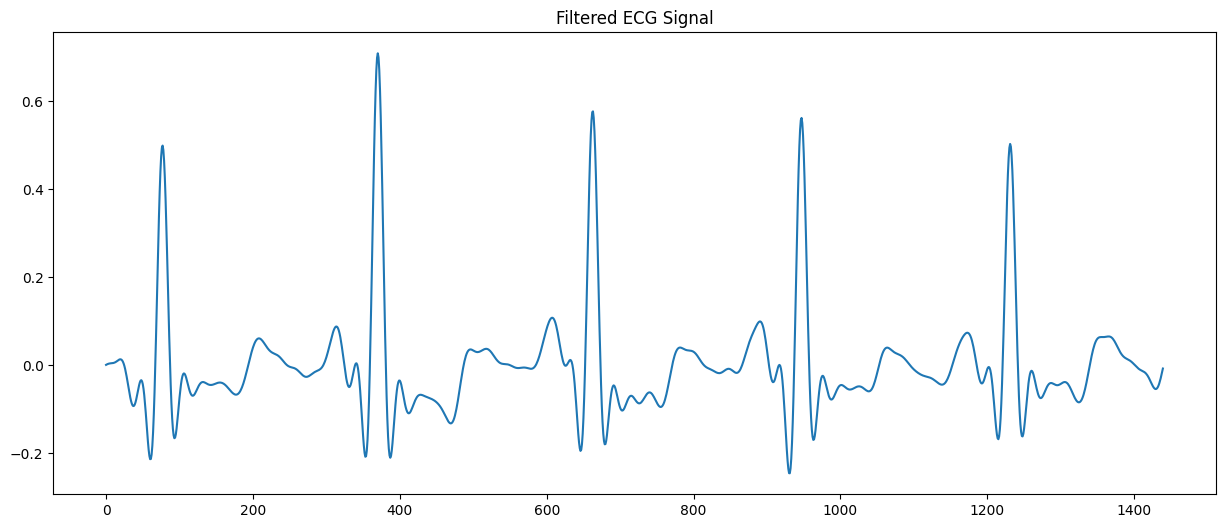

In [56]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# filtered_signal = butter_bandpass_filter(normalized_signal, 0.5, 40, fs)
filtered_signal = butter_bandpass_filter(normalized_signal, 1, 15, fs)
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)
plt.title("Filtered ECG Signal")
plt.show()

 Feature Extraction

Detected 5 R-peaks


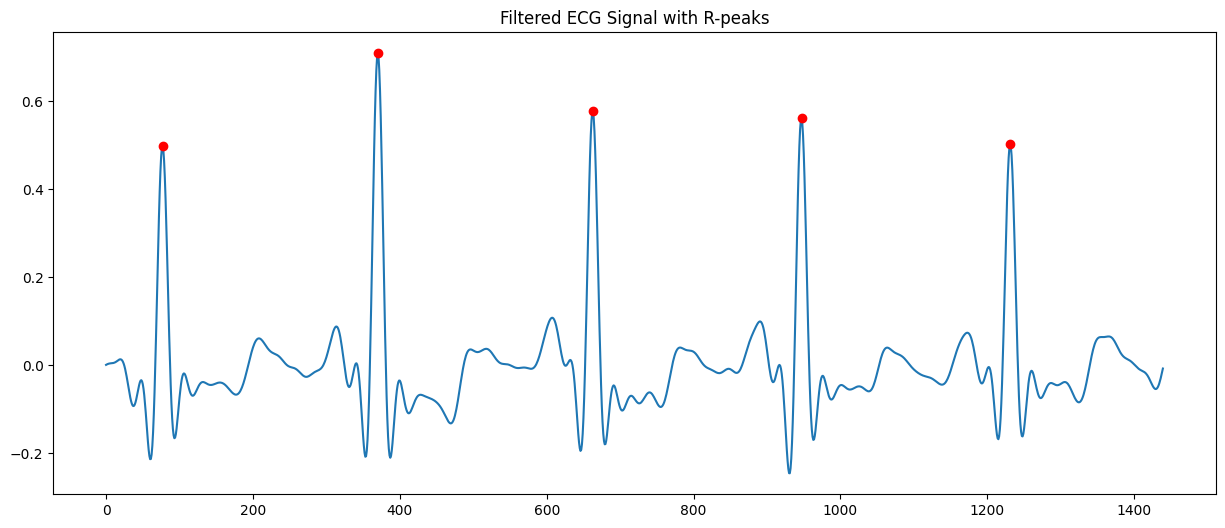

In [57]:
def detect_r_peaks(signal, fs):
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=fs*0.6)
    return peaks

r_peaks = detect_r_peaks(filtered_signal, fs)
print(f"Detected {len(r_peaks)} R-peaks")
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro')
plt.title("Filtered ECG Signal with R-peaks")
plt.show()


QRS Complex Detection (Pan-Tompkins)

In [58]:
def pan_tompkins_qrs_detection(signal, fs):
    # Bandpass filter (already done in preprocessing)
    diff_signal = np.diff(signal)
    squared_signal = diff_signal ** 2
    # window_size = int(0.15 * fs)
    window_size = int(0.11 * fs)
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size)
    threshold = 0.5 * np.max(integrated_signal)
    qrs_peaks, _ = find_peaks(integrated_signal, height=threshold)
    return qrs_peaks

qrs_peaks = pan_tompkins_qrs_detection(filtered_signal, fs)
# print(f"Detected {len(qrs_peaks)} QRS peaks")
# plt.figure(figsize=(15, 6))
# plt.plot(filtered_signal)   
# plt.plot(qrs_peaks, filtered_signal[qrs_peaks], 'ro')
# plt.title("Filtered ECG Signal with QRS peaks")
# plt.show()

Detect Q, S, P, T Peaks

Detected 5 Q-peaks at locations: [  60  353  646  931 1215]
Detected 5 S-peaks at locations: [  93  387  679  963 1248]
Detected 4 P-peaks at locations: [ 314  607  890 1173]
Detected 5 T-peaks at locations: [ 208  518  782 1064 1365]


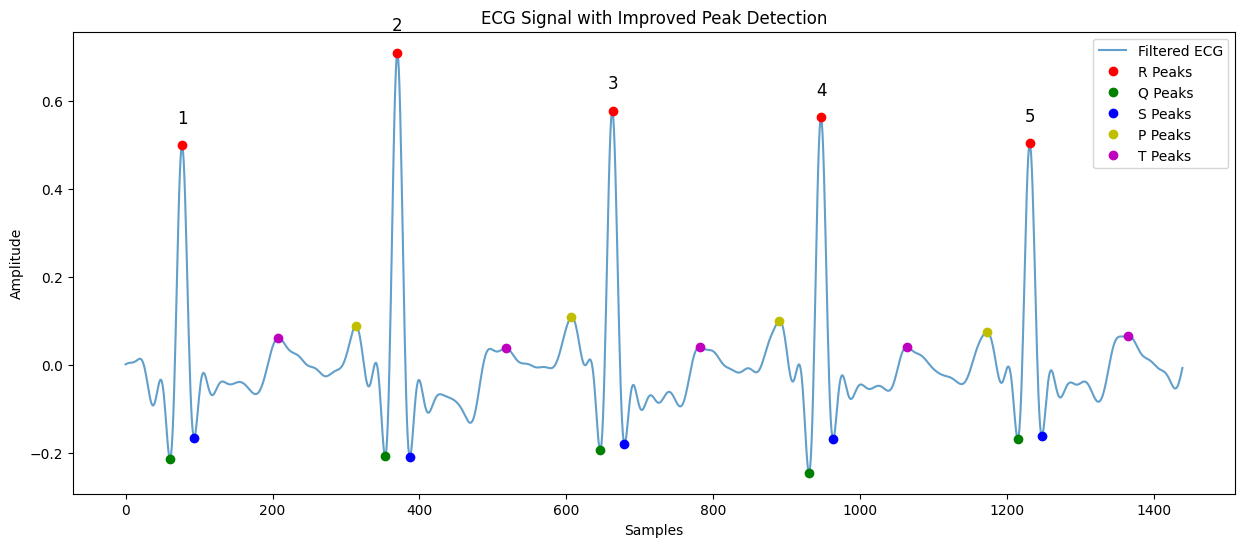

In [61]:
def detect_qs_peaks(signal, r_peaks, fs):
    q_peaks, s_peaks = [], []
    search_window = int(0.05 * fs)  # 50 ms before/after R-peak
    
    for r in r_peaks:
        # Q-peak: Search 50 ms before R-peak
        q_start = max(0, r - search_window)
        q_window = signal[q_start:r]
        if len(q_window) > 0:
            q_peak = np.argmin(q_window) + q_start
            q_peaks.append(q_peak)
        else:
            q_peaks.append(np.nan)
        
        # S-peak: Search 50 ms after R-peak
        s_end = min(len(signal), r + search_window)
        s_window = signal[r:s_end]
        if len(s_window) > 0:
            s_peak = np.argmin(s_window) + r
            s_peaks.append(s_peak)
        else:
            s_peaks.append(np.nan)
    
    return np.array(q_peaks), np.array(s_peaks)

def detect_pt_peaks(signal, r_peaks, fs):
    p_peaks, t_peaks = [], []
    
    # Filter out NaN values from r_peaks
    r_peaks = r_peaks[~np.isnan(r_peaks)].astype(int)

    for i, r in enumerate(r_peaks):
        # P-wave: Search before R-peak
        if i > 0:
            prev_t = t_peaks[i-1] if not np.isnan(t_peaks[i-1]) else 0
            p_start = max(prev_t + int(0.1 * fs), r - int(0.3 * fs))
        else:
            p_start = max(0, r - int(0.3 * fs))
        
        p_window = signal[int(p_start):r]
        p_peak, _ = find_peaks(p_window, prominence=0.1 * np.max(signal))  
        if len(p_peak) > 0:
            p_peaks.append(p_peak[0] + int(p_start))
        else:
            p_peaks.append(np.nan)
        
        # T-wave: Search after R-peak
        # t_start = r + int(0.2 * fs) 
        t_start = r + int(0.2 * fs)  
        # t_end = min(len(signal), r + int(0.4 * fs))
        t_end = min(len(signal), r + int(0.5 * fs))
        t_window = signal[t_start:t_end]
        t_peak, _ = find_peaks(t_window, prominence=0.01 * np.max(signal))
        if len(t_peak) > 0:
            t_peaks.append(t_peak[0] + t_start)
        else:
            t_peaks.append(np.nan)
    
    return np.array(p_peaks), np.array(t_peaks)



q_peaks, s_peaks = detect_qs_peaks(filtered_signal, r_peaks,fs)
p_peaks, t_peaks = detect_pt_peaks(filtered_signal, r_peaks, fs)

valid_p_peaks = p_peaks[~np.isnan(p_peaks)].astype(int)
valid_r_peaks = r_peaks[~np.isnan(r_peaks)].astype(int)

# Print the detected peak counts and locations
print(f"Detected {len(q_peaks)} Q-peaks at locations: {q_peaks}")
print(f"Detected {len(s_peaks)} S-peaks at locations: {s_peaks}")
print(f"Detected {len(valid_p_peaks)} P-peaks at locations: {valid_p_peaks}")
print(f"Detected {len(t_peaks)} T-peaks at locations: {t_peaks}")

plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG', alpha=0.7)

# annotate r-peaks with numbers
for i, r in enumerate(valid_r_peaks):
    plt.text(r, filtered_signal[r] + 0.05, str(i+1), color='black', fontsize=12, ha='center')  # Annotate with peak number

plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.plot(q_peaks[~np.isnan(q_peaks)].astype(int), filtered_signal[q_peaks[~np.isnan(q_peaks)].astype(int)], 'go', label='Q Peaks')
plt.plot(s_peaks[~np.isnan(s_peaks)].astype(int), filtered_signal[s_peaks[~np.isnan(s_peaks)].astype(int)], 'bo', label='S Peaks')
plt.plot(p_peaks[~np.isnan(p_peaks)].astype(int), filtered_signal[p_peaks[~np.isnan(p_peaks)].astype(int)], 'yo', label='P Peaks')
plt.plot(t_peaks[~np.isnan(t_peaks)].astype(int), filtered_signal[t_peaks[~np.isnan(t_peaks)].astype(int)], 'mo', label='T Peaks')

plt.title('ECG Signal with Improved Peak Detection')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Calculate Dynamic Features

In [64]:
rr_intervals = np.diff(r_peaks) / fs  # In seconds
heart_rate = 60 / np.mean(rr_intervals)
hrv = (np.max(rr_intervals) - np.min(rr_intervals)) * 100
print(f"Heart rate: {heart_rate:.2f} bpm")
print(f"HRV: {hrv:.2f} ms")

Heart rate: 74.87 bpm
HRV: 2.50 ms


R/P Ratio

In [65]:
# Ensure both arrays have the same length
min_length = min(len(valid_r_peaks), len(valid_p_peaks))
valid_r_peaks = valid_r_peaks[:min_length]
valid_p_peaks = valid_p_peaks[:min_length]

# Extract amplitudes
r_amplitudes = filtered_signal[valid_r_peaks]
p_amplitudes = filtered_signal[valid_p_peaks]

# Avoid division by zero
safe_p_amplitudes = np.where(p_amplitudes == 0, np.nan, p_amplitudes)
r_to_p_ratio = np.nanmean(r_amplitudes / safe_p_amplitudes)  # Ignore NaN values

print(f"R-to-P amplitude ratio: {r_to_p_ratio:.2f}")


R-to-P amplitude ratio: 6.43


Rule-Based Classification

In [67]:
classification = []

# Rule-based checks
if heart_rate < 60:
    classification.append("Bradycardia")
elif heart_rate > 100:
    classification.append("Tachycardia")

# Check for irregular RR intervals (AFib)
rr_std = np.std(rr_intervals)
if rr_std > 0.15 and len(p_peaks) < 0.5 * len(r_peaks):  # Arbitrary thresholds
    classification.append("Atrial Fibrillation (Suspected)")

# If no conditions met, classify as Normal
if not classification:
    classification.append("Normal - healthy")

# Print results
print("Classification Results:", ", ".join(classification))

Classification Results: Normal - healthy


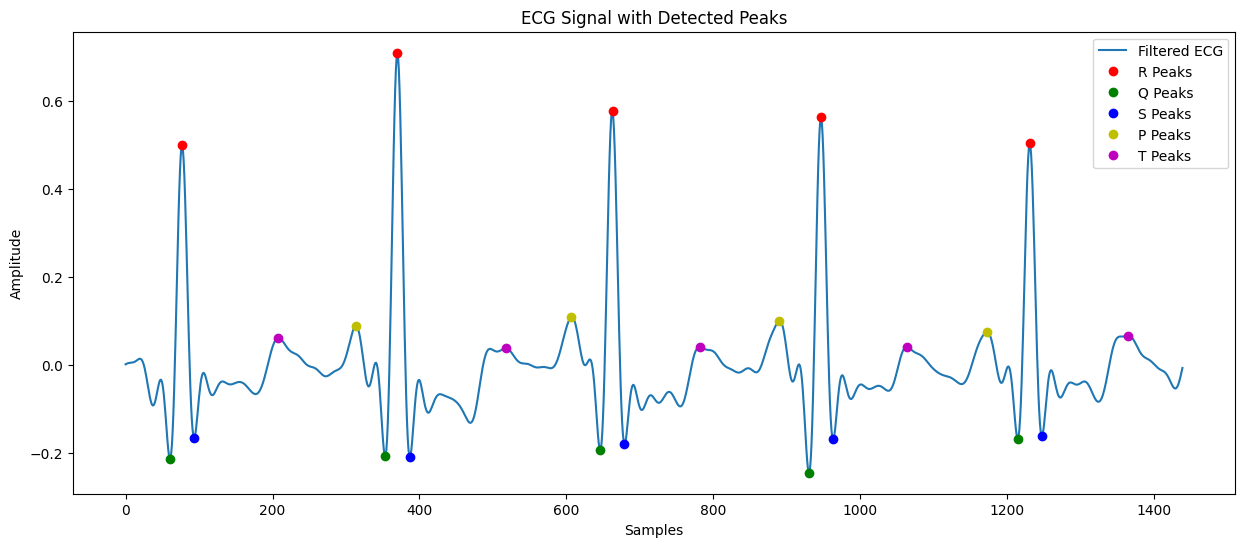

In [68]:
plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG')
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.plot(q_peaks[~np.isnan(q_peaks)].astype(int), filtered_signal[q_peaks[~np.isnan(q_peaks)].astype(int)], 'go', label='Q Peaks')
plt.plot(s_peaks[~np.isnan(s_peaks)].astype(int), filtered_signal[s_peaks[~np.isnan(s_peaks)].astype(int)], 'bo', label='S Peaks')
plt.plot(p_peaks[~np.isnan(p_peaks)].astype(int), filtered_signal[p_peaks[~np.isnan(p_peaks)].astype(int)], 'yo', label='P Peaks')
plt.plot(t_peaks[~np.isnan(t_peaks)].astype(int), filtered_signal[t_peaks[~np.isnan(t_peaks)].astype(int)], 'mo', label='T Peaks')
plt.title('ECG Signal with Detected Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

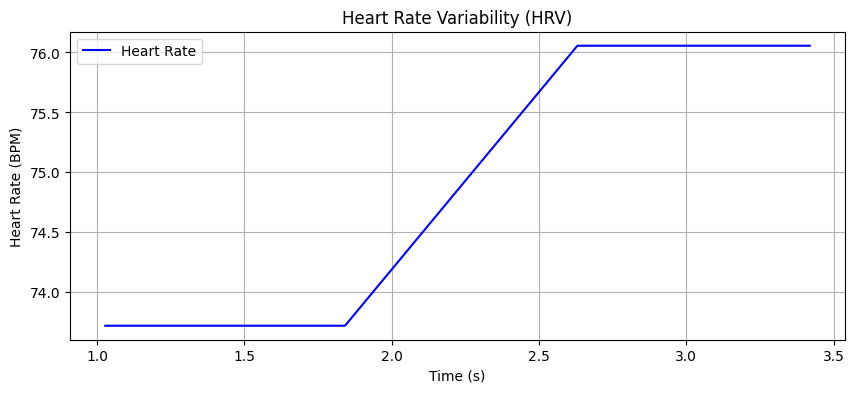

In [69]:
plt.figure(figsize=(10, 4))
plt.plot(r_peaks[1:]/fs, 60/rr_intervals, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (BPM)')
plt.legend(['Heart Rate'])
plt.title('Heart Rate Variability (HRV)')
plt.grid(True)
plt.show()